# Antoni Ballaun 140 447
# 95.01% accuracy CNN on fashion MINST

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, regularizers
import numpy
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

### Data preparation

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# reshape and normalize 
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# One hot encode
train_labels = to_categorical(train_labels,10)
test_labels = to_categorical(test_labels,10)

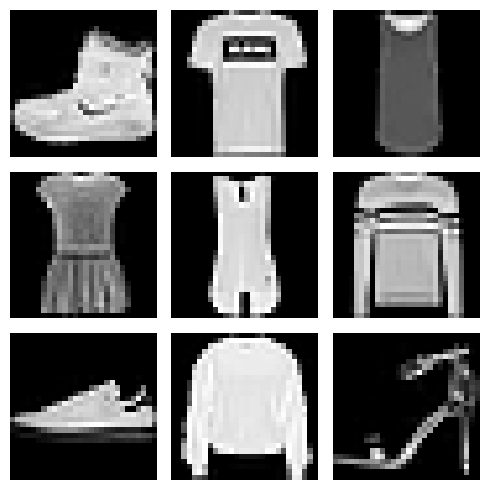

In [3]:

plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

#### For the 95% CNN the process is a little different, i have added a little data augmentation to prevent the model from overfitting 

In [4]:
(train_images_for_aug, train_labels_for_aug), (test_images_for_aug, test_labels_for_aug) = tf.keras.datasets.fashion_mnist.load_data()
train_images_for_aug = train_images_for_aug.reshape(-1, 28, 28, 1).astype('float32')  # No normalizng, lataer  during augmentation
test_images_for_aug = test_images_for_aug.reshape(-1, 28, 28, 1).astype('float32') / 255.0  # test normalized since it will not be augmented 

# One-hot encode
train_labels_for_aug = to_categorical(train_labels_for_aug, 10).astype('float32')
test_labels_for_aug = to_categorical(test_labels_for_aug, 10).astype('float32')

datagen = ImageDataGenerator(rescale=1./255, # normalizing
                            rotation_range=5,
                            zoom_range=0.05,
                            shear_range=0.05)
train_generator = datagen.flow(train_images_for_aug, train_labels_for_aug, batch_size=64)


#### After that some images slightly rotated, zoomed or sheared. Also train_generator is an iterator, during every epoch the augmentaion will be different, helping with generalization

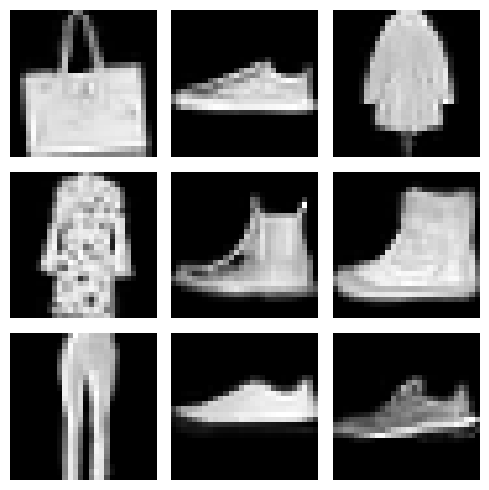

In [5]:
images, labels = next(train_generator)

plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

#### As seen above the augmentation is very slight, if the model didn't reach 95% i would have increased it further

### Basic model (around 93 acc)

##### From doing a grid search(filter sizes and amount of layers and batch size) and studying litearture of other CNN's I came up with this basic model

In [6]:
def build_model():
    model = models.Sequential()
    
    # 2 convs than maxpool
    model.add(layers.Conv2D(32, (3, 3), input_shape=(28, 28, 1),))
    model.add(layers.Activation('relu'))

    model.add(layers.Conv2D(32, (3, 3),))
    model.add(layers.Activation('relu'))

    model.add(layers.MaxPooling2D((2, 2)))

     # 2 convs than maxpool
    model.add(layers.Conv2D(64, (3, 3),))
    model.add(layers.Activation('relu'))


    model.add(layers.Conv2D(64, (3, 3),))
    model.add(layers.Activation('relu'))

    model.add(layers.MaxPooling2D((2, 2)))

    # Suprisingly one big dense layer did better than one big one small for ex. (512 -> 256 )
    model.add(layers.Flatten())
    model.add(layers.Dense(512))
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [7]:
model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 594,922 (2.27 MB)

 Trainable params: 594,922 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

#### The model has
<ul>
    <li>2 conv layers with 32 filters followed by max pool</li>
    <li>another 2 conv layers this time with 64 filters and followed again by 1 max pool</li>
    <li>after that flattening and one dense layer of 512 neurons</li>
    <li>all activation functions are just Relu except for the output layer which uses Softmax since we predicting from multiple categories</li>
    <li>Loss function is the standard categorical_crossentropy and adam as the optimizer</li>
    <li>~1.6mil parameters</li>
</ul>

#### Also added some callbacks


In [8]:
# halves the lr after 4 epochs of no improvment
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',       
    factor=0.5,               
    patience=3,               
    min_lr=1e-10,              
    verbose=0
)

# early stopping which was very useful for grid search if the model has stopped improving
early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0,
    start_from_epoch=5 
)

# This checks after each eppoch if the val_accuracy is best yet and if it is, the model is saved to a .keras file
checkpoint_cb = ModelCheckpoint(
    filepath='best_model.keras',    
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0,
)

#### The biggest problem was overfitting, below small training example

In [9]:
training = model.fit(train_images,train_labels,
          validation_data=(test_images, test_labels),
          batch_size=64,
          epochs=10,
          verbose=0,
          callbacks=[lr_scheduler,checkpoint_cb, early_stopping_cb]
        )

y_pred_probs = model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(test_labels, axis=1) 
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9223


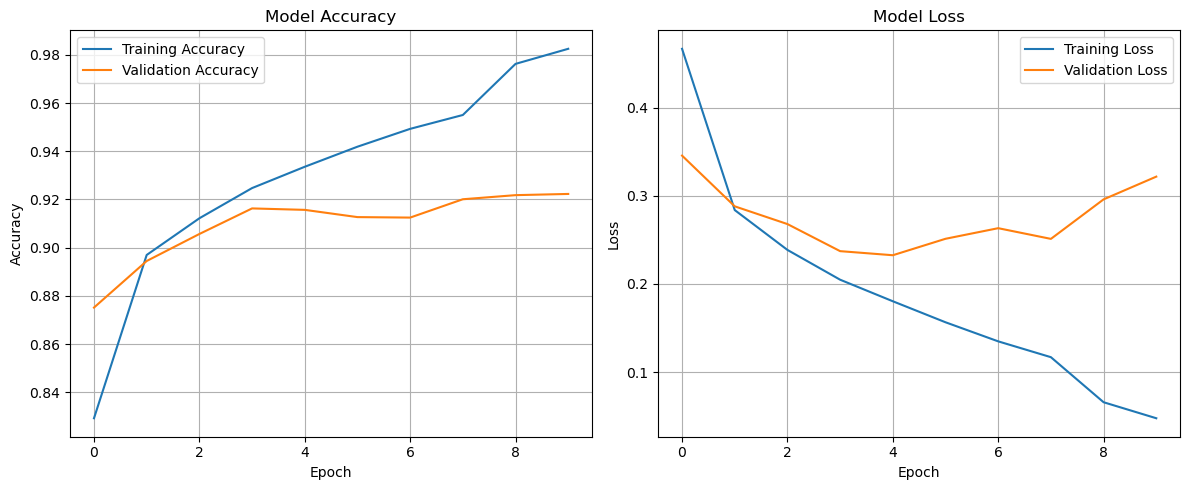

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# accuracy
axs[0].plot(training.history['accuracy'], label='Training Accuracy')
axs[0].plot(training.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# loss
axs[1].plot(training.history['loss'], label='Training Loss')
axs[1].plot(training.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

#### This model was already very good hitting almost 93% if left for more epochs but it was clearly overfitting

### 95.01% accuracy model

#### To reach 95 accuracy I added the following things to the model
1. Batch normalization after each layer: it normalizes the outputs and than adjusts them based on learneble parametrs. This helps with overfiting and training speed.
2. Dropout chosen thorught grid search, small for conv blocks larger for dense layer. This also helps with overfitting.
3. Padding ='same' so that the conv blocks dont reducce size.
4. Label smoothing this transforms labels the correct label is equal to 1 - ε and all other ε/(K - 1) where K is the number of labels
5. AdamW optimizer which is the same as Adam but can add weight decay in a sensible way which is good for generalization.
6. Cosine decay which is better for scheduling in AdamW. It slowly lowers the learning rate over time.
7. Also I trained the model on the augmented training data 

In [11]:
def build_model(steps_per_epoch):
    model = models.Sequential()
    
    # Conv + BN + ReLU blocks
    model.add(layers.Conv2D(32, (3, 3), input_shape=(28, 28, 1),padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(32, (3, 3),padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.15))

    model.add(layers.Conv2D(64, (3, 3),padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.15))

    model.add(layers.Flatten())
    model.add(layers.Dense(512))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(10, activation='softmax'))

  
    total_epochs = 100 # I made a mistake here it should have been 200
    decay_steps = steps_per_epoch * total_epochs

    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-3,
        decay_steps=decay_steps,
        alpha=1e-5  # the lr will not go below 1e-8 i choose this arbitrarly
    )

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=lr_schedule,
        weight_decay=1e-5
    )

    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])

    return model


In [12]:
# No need for reduce lr on plateau
early_stopping_cb = EarlyStopping(
    monitor='val_accuracy',
    patience=40,
    restore_best_weights=True,
    verbose=0,
    start_from_epoch=10 
)

checkpoint_cb = ModelCheckpoint(
    filepath='best_model.keras',    
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0,
)


#### Training 

In [13]:
(train_images_for_aug, train_labels_for_aug), (test_images_for_aug, test_labels_for_aug) = tf.keras.datasets.fashion_mnist.load_data()
train_images_for_aug = train_images_for_aug.reshape(-1, 28, 28, 1).astype('float32')  # No normalizng, lataer  during augmentation
test_images_for_aug = test_images_for_aug.reshape(-1, 28, 28, 1).astype('float32') / 255.0  # test normalized since it will not be augmented 

# One-hot encode
train_labels_for_aug = to_categorical(train_labels_for_aug, 10).astype('float32')
test_labels_for_aug = to_categorical(test_labels_for_aug, 10).astype('float32')

datagen = ImageDataGenerator(rescale=1./255, # normalizing
                            rotation_range=5,
                            zoom_range=0.05,
                            shear_range=0.05)
train_generator = datagen.flow(train_images_for_aug, train_labels_for_aug, batch_size=64)


In [14]:
batch_size = 64
epochs = 200
steps_per_epoch = train_images.shape[0] // batch_size

model = build_model(steps_per_epoch)

model.fit(train_generator,
          validation_data=(test_images_for_aug, test_labels_for_aug),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[checkpoint_cb, early_stopping_cb]
        )

Epoch 1/200
938/938 ━━━━━━━━━━━━━━━━━━━━ 74s 75ms/step - accuracy: 0.8018 - loss: 1.0401 - val_accuracy: 0.8916 - val_loss: 0.7640
Epoch 2/200
938/938 ━━━━━━━━━━━━━━━━━━━━ 72s 77ms/step - accuracy: 0.8953 - loss: 0.7638 - val_accuracy: 0.9139 - val_loss: 0.7208
Epoch 3/200
938/938 ━━━━━━━━━━━━━━━━━━━━ 71s 75ms/step - accuracy: 0.9112 - loss: 0.7258 - val_accuracy: 0.9055 - val_loss: 0.7165
Epoch 4/200
938/938 ━━━━━━━━━━━━━━━━━━━━ 71s 75ms/step - accuracy: 0.9178 - loss: 0.7089 - val_accuracy: 0.9165 - val_loss: 0.7020
Epoch 5/200
938/938 ━━━━━━━━━━━━━━━━━━━━ 72s 76ms/step - accuracy: 0.9248 - loss: 0.6939 - val_accuracy: 0.9235 - val_loss: 0.7001
Epoch 6/200
938/938 ━━━━━━━━━━━━━━━━━━━━ 71s 76ms/step - accuracy: 0.9311 - loss: 0.6804 - val_accuracy: 0.9297 - val_loss: 0.6800
Epoch 7/200
938/938 ━━━━━━━━━━━━━━━━━━━━ 71s 75ms/step - accuracy: 0.9343 - loss: 0.6725 - val_accuracy: 0.9285 - val_loss: 0.6699
Epoch 8/200
938/938 ━━━━━━━━━━━━━━━━━━━━ 70s 75ms/step - accuracy: 0.9372 - loss: 0

##### Highest accuracy epoch 46

##### The model is saved in .keras format which saves both the architecture and weights

In [17]:
model = load_model('best_model.keras')

y_pred_probs = model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(test_labels, axis=1) # Convert back from one hot

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Accuracy: 0.9501


In [16]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 5,034,431 (19.20 MB)

 Trainable params: 1,677,674 (6.40 MB)

 Non-trainable params: 1,408 (5.50 KB)

 Optimizer params: 3,355,349 (12.80 MB)